In [1]:
# Activate the library
import Pkg
Pkg.activate("../")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [2]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Exploration: Looking for the relaxation time
The first thing I want to know is how long I should look, for that I test the relaxation time.

In [3]:
EPS = 0e-5 # Tolerance for the distance respect to the Frobenious norm
delta= 0.0 # Detuning
omega = 0.5 # Rabi Frequency
gamma = 0.4
H = delta*QuTaM.sigma_z + omega*QuTaM.sigma_x

psi0 = zeros(ComplexF64, 2)
psi0[1] = 1 # Initial condition

sys = System(H, # Hamiltonian
[sqrt(gamma)*QuTaM.sigma_m]) #Jump Operators
params = SimulParameters(psi0,
    50.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    250, # Number of trajectories
    75_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)



SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=250)
multiplier=4.0
tf=50.0
dt=0.0026666666666666666
eps=0.001)

In [4]:
QuTaM.sigma_z

2×2 Matrix{ComplexF64}:
 -1.0+0.0im  0.0+0.0im
  0.0+0.0im  1.0+0.0im

In [5]:
function rf_de!(dr, r, p, t)
    #gamma = QuTaM.rf_gamma
    #delta = QuTaM.rf_delta
    #omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [6]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [7]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [8]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

Sampling... 100%|████████████████████████████████████████| Time: 0:00:34


In [9]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  0.913127 seconds (7.50 M allocations: 334.659 MiB, 5.67% gc time, 10.82% compilation time)


In [10]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.057515 seconds (13.31 k allocations: 516.305 KiB, 98.68% compilation time)


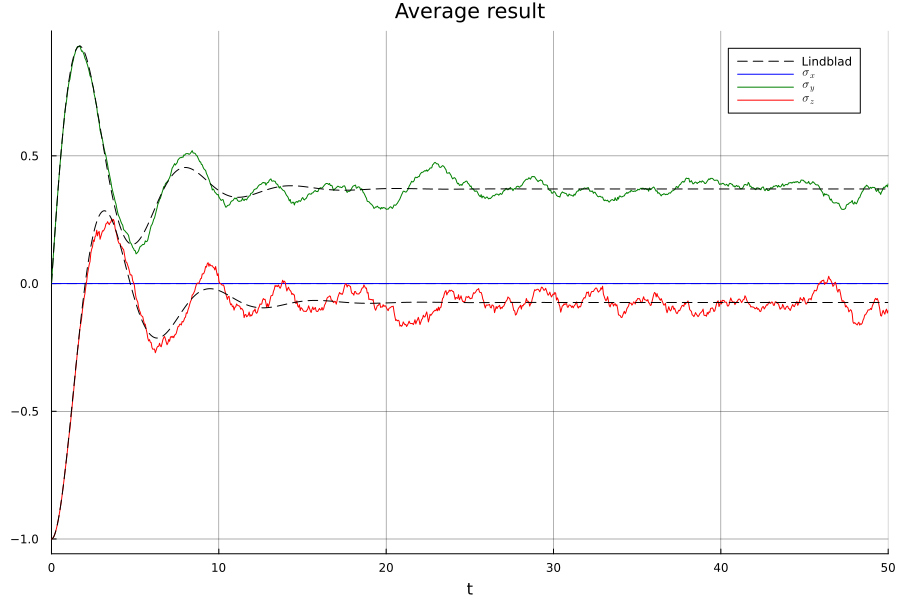

In [11]:
index_range = 1:size(t_given)[1]

plot(sol[index_range], idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
plot!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:blue)

plot!(t_given[index_range], r_avg[index_range, 2],  label=L"\sigma_y" , seriescolor=:green)
plot!(sol[index_range], idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)

plot!(t_given[index_range], r_avg[index_range, 3],  label=L"\sigma_z" , seriescolor=:red)
plot!(sol[index_range], idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)

plot!(title="Average result", xlabel="t", grid=:true, gridalpha=0.6, size=(900,600))

# Calculating the Monitoring Operator
The key to access the FI is to use the monitoring operator:

$$ |\xi_N(t_n,...,t_1)\rangle = \frac{\partial_\theta|\psi(t_n, ...,t_1) \rangle}{\langle\psi(t_n, ...,t_1)|\psi(t_n, ...,t_1) \rangle}$$

so the first thing in order is to obtain this thing, conditioned on a trajectory.

In [12]:
traj = sample_clicks[3]
QuTaM.states_at_jumps(traj, sys, params.psi0; normalize=false)

13×2 Matrix{ComplexF64}:
         0.0+0.240171im    0.0+0.0im
    0.069102+0.0im         0.0+0.0im
         0.0-0.0326277im   0.0+0.0im
  -0.0149647+0.0im         0.0+0.0im
         0.0+0.00637771im  0.0+0.0im
  0.00304707+0.0im         0.0+0.0im
         0.0-0.00126088im  0.0+0.0im
 -0.00033891+0.0im         0.0+0.0im
         0.0-8.14538e-5im  0.0+0.0im
 -3.75368e-5+0.0im         0.0+0.0im
         0.0+1.54286e-5im  0.0+0.0im
 -3.05056e-6+0.0im         0.0+0.0im
         0.0+7.84273e-7im  0.0+0.0im

In [13]:
function MonitoringAtJumps(traj::Trajectory, sys::System, dHe::Matrix{ComplexF64}, dLs::Vector{Matrix{ComplexF64}},
         params::SimulParameters) 
    njumps = size(traj)[1]
    xis = zeros(ComplexF64, njumps, sys.NLEVELS)
    tmp1 = zeros(ComplexF64, sys.NLEVELS) #for the psitilde
    tmp2 = zeros(ComplexF64, sys.NLEVELS) #for the derivative of psitilde
    # 1. intialize the monitoring
    label = traj[1].label
    tau = traj[1].time
    tmp1 .= psi0
    # 1. Iterate over the clicks
    for k in 1:njumps
        label = traj[k].label
        tau = traj[k].time
        tmp2 .= dLs[label]*exp(-1im*tau*sys.Heff)*tmp1 + 
                sys.Ls[label]*-1im*tau*dHe*exp(-1im*tau*sys.Heff) * tmp1+
                sys.Ls[label]*exp(-1im*tau*sys.Heff)*tmp2
        tmp1 .= sys.Ls[label]*exp(-1im*tau*sys.Heff)*tmp1 
        xis[k, :] = tmp2/dot(tmp1, tmp1) 
    end 
    return xis
end 

MonitoringAtJumps (generic function with 1 method)

In [14]:
traj = sample_clicks[3]
dHe = QuTaM.sigma_z
dLs = [zeros(ComplexF64, sys.NLEVELS, sys.NLEVELS)]
MonitoringAtJumps(traj, sys, dHe, dLs, params)

13×2 Matrix{ComplexF64}:
     40.938+0.0im        0.0+0.0im
        0.0-211.401im    0.0+0.0im
   -543.268+0.0im        0.0+0.0im
        0.0+1333.65im    0.0+0.0im
    3720.09+0.0im        0.0+0.0im
        0.0-8732.45im    0.0+0.0im
   -22515.8+0.0im        0.0+0.0im
        0.0+86639.7im    0.0+0.0im
 -4.66234e5+0.0im        0.0+0.0im
        0.0+1.07203e6im  0.0+0.0im
  2.72225e6+0.0im        0.0+0.0im
        0.0+1.63679e7im  0.0+0.0im
  6.48422e7+0.0im        0.0+0.0im

In [ ]:
"""

MonitoringInBetween( traj::Trajectory, sys::System, dHe::Matrix{ComplexF64},
                     params::SimulParameters,
                    t_given::Vector{Float64}) -> Array{ComplexF64}

- `t_given::Vector{Float64}`: times at which the trajectory is to be evalauted
- `traj::Trajectory`: the trajectory
- `sys::System`: the system to which the trajectory corresponds
- `psi0::Vector{ComplexF63}`: the initial state of the trajectory
- `dHe::Matrix{ComplexF64}`
- `dLs::Vector{Matrix{ComplexF63}}`
"""
function MonitoringInBetween(
        traj::Trajectory, sys::System, dHe::Matrix{ComplexF64}, dLs::Matrix{ComplexF64},
         params::SimulParameters, t_given::Vector{Float64}) 
    ntimes = size(t_given)[1]
    tmp1 = zeros(ComplexF64, sys.NLEVELS)
    psitilde = zeros(ComplexF64, sys.NLEVELS)
    # Obtain the unnormalized jump states
    jump_states = states_at_jumps(traj, sys, psi0; normalize=false)
    inbetween_states = evaluate_at_t(t_give, traj, sys, psi0; normalize=false)
    jump_xis = MonitoringAtJumps(traj, sys, dHe, dLs, params)
    njumps = size(jump_states)[1]
    t_ = 0
    counter = 1
    counter_c = 1
    # TODO: INTRODUCE THIS EDGE CASE
    # Special case: if the time array is empty, return an empty array
    #if isempty(t_given)
    #    return Array{ComplexF64}(undef, 0, 0) # empty 2 dimensional array
    #end

    xis = Array{ComplexF64}(undef, ntimes, sys.NLEVELS)
    ###  TODO: INTRODUCE EDGE CASE
    # Edge case: if the trajectory is empty, evaluate exponentials and return
    #if isempty(traj)
    #    while counter <= ntimes
    #        psi .= exp(-1im*(t_given[counter])*sys.Heff) * psi
    #        psi .= psi/norm(psi)
    #        for k in 1:sys.NLEVELS
    #            states[counter, k] = psi[k]
    #        end
    #        counter = counter + 1
    #        if counter > ntimes
    #            break
    #        end
    #    end
    #    return states
    #end
    # All the xis before the first jump can be handled like this:
    while (t_given[counter] < traj[counter_c].time) && (counter <= ntimes)
            # 1. Calculate the derivative
            tmp1 .= -1im*(t_given[counter])*dHe*inbetween_states[counter]
            # 2. normalize and add
            xis[counter, :] = tmp1 ./ dot(inbetween_states[counter], inbetween_states[counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
    end
    ################## TODO: IMPLEMENT FOR THE REST OF THE CASES####################
    t_ = t_ + traj[counter_c].time
    counter_c = counter_c + 1
    while (counter_c <= njumps) && (counter <= ntimes)
        timeclick = traj[counter_c].time
        while (t_ < t_given[counter] < t_ + timeclick) && (counter <= ntimes)
             psi .= exp(-1im*(t_given[counter] - t_)*sys.Heff) * jump_states[counter_c-1, :]
             psi .= psi/norm(psi)
             for k in 1:sys.NLEVELS
                 states[counter, k] = psi[k]
             end
             counter = counter + 1
             if counter > ntimes
                 break
             end
         end
       t_ = t_ + timeclick
       counter_c = counter_c + 1
    end

    while counter <= ntimes
        psi .= exp(-1im*(t_given[counter] - t_)*sys.Heff) * jump_states[njumps, :]
        psi .= psi/norm(psi)
        for k in 1:sys.NLEVELS
            states[counter, k] = psi[k]
        end
        counter = counter + 1
    end
    return states 
end

 